# 1. Preparing our data

## 1.1 Description of the raw data

Our raw data is given in the form of three vectors:

* x: energy
* y: number of photons
* y_err: error in y, which should be in our case equal to $\sqrt{y}$

These vectors are placed in the file corresponding to that spectrum, for example

|    X,eV     |   Y      | Y err    |
|----------|----------|----------|
| 6025.88  | 588.0    | 24.25    |
| 6063.11  | 637.0    | 25.24    |
| 6100.57  | 651.0    | 25.51    |
| 6138.25  | 580.0    | 24.08    |
| 6176.17  | 676.0    | 26.0     |
| 6214.33  | 768.0    | 27.71    |

## 1.2 Lower the number of channels

Our spectra are given in the energy range $\left[100,300k\right]$ eV. But we are interested mostly on ~ $\left[1,50\right]$ keV. In addition, we want to reduce the number of channels (energy-bins) because it will have a negative impact on the performance of the DL (Deep Learning) model. There are different ways to achieve this, and we can change this later, therefore now we will simply average neighbor energy bins. This will also help us to smoothen a little bit the spectra. 


The number of channels in the energy distribution is 159


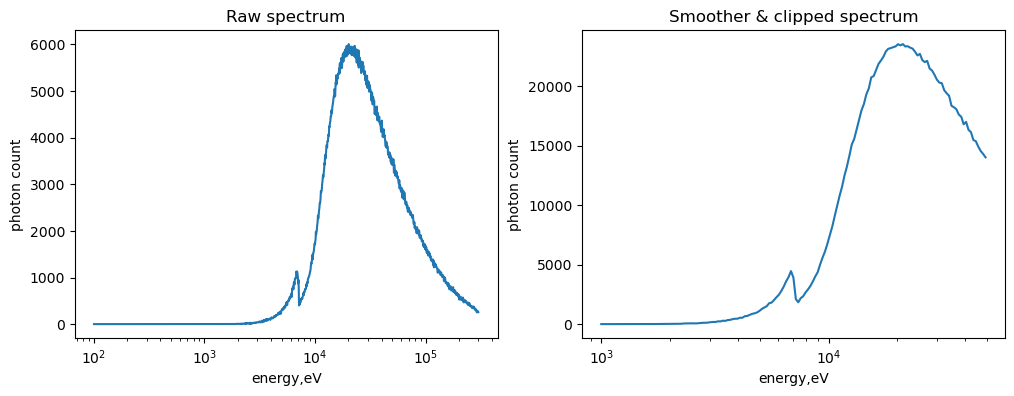

In [1]:
from one_time_utilities import *

x_raw, y_raw, _ = x_y_z(path=".dummydata/224_-1_1xfe_6070_51_8.9e+20_1.1e+26_33_CONTINUUM_NONE.spectrum")

x_smooth,y_smooth = reduce_energy_bins_number(x_raw,y_raw,times_=2)
x_clipped, y_clipped = clip_spectrum(x_smooth,y_smooth,energy_left=1e3,energy_right=50e3)

plot_pair_spectra(x_raw,y_raw,x_clipped,y_clipped,title_left="Raw spectrum",title_right="Smoother & clipped spectrum")

print(f"The number of channels in the energy distribution is {len(x_clipped)}")

## 1.3 Normalization

In order to pass our data into the DL model we will normalize the spectra with the given formula (see: https://arxiv.org/abs/2206.04602):

$$
y = \frac{y_{count} - \overline{y_{count}}}{\sigma (y_{count})}
$$

By using the pevious formula, all our spectra will have the same mean value of $0$, and the same standard deviation of $1$.

Later we will pass that normalized $y$ to our DL model.

Mean value: 0.00,    Stdev: 1.00


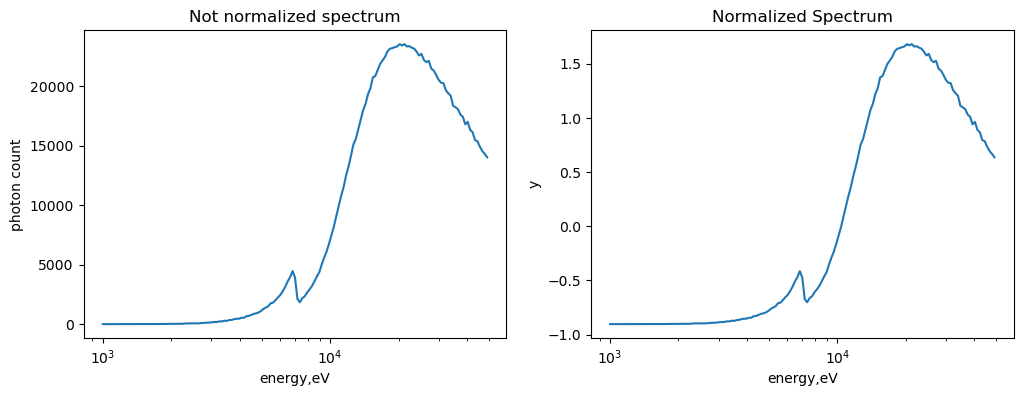

In [2]:
x_normalized, y_normalized = normalize_spectrum(x_clipped,y_clipped)

plot_pair_spectra(x_clipped,y_clipped,
                  x_normalized,y_normalized,
                  title_left="Not normalized spectrum", 
                  title_right="Normalized Spectrum", 
                  y_label_right="y")

print(f"Mean value: {np.mean(y_normalized):.2f},    Stdev: {np.std(y_normalized):0.2f}")

## 1.4 Finishing the preparation of the spectra

Now we can combine the previous operations into a single function.

Mean value: 0.00,    Stdev: 1.00


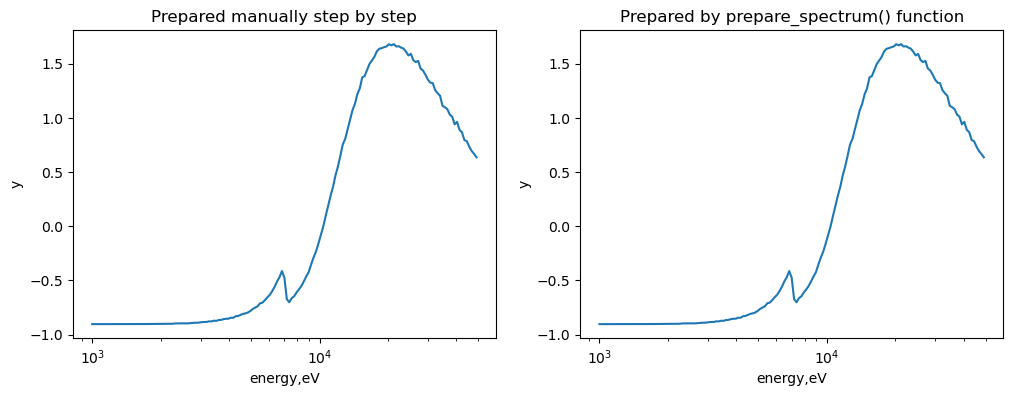

In [3]:
x_prepared, y_prepared = prepare_spectrum(x_raw=x_raw,y_raw=y_raw,energy_left=1e3, energy_right=50e3, squeezin_factor=2)

# Let's compare both retults, we expect them to be equal
plot_pair_spectra(x_normalized,y_normalized,
                  x_prepared,y_prepared,
                  title_left="Prepared manually step by step", 
                  title_right="Prepared by prepare_spectrum() function", 
                  y_label_right="y",y_label_left="y")

print(f"Mean value: {np.mean(y_normalized):.2f},    Stdev: {np.std(y_normalized):0.2f}")

## 1.4 Build the spectrum class

We now need to extract the label data from the spectrum file.

Each spectrum file name is given in the the form:

* `nha`: average colum density in $cm^{-2}$
* `n`: average number of clouds
* `afe`: Iron abundance, relative to the standard solar abundance
* `alpha`: viewing angle
* `col_density_description`: describes the column density intervals
* `nh`: column density interval id on the line of sight
* `component`: spectrum component type
* `fluorescent_line`: if the spectrum component corresponds to a fluorescent line, then this parameter indicates which line (e.g. FeKalpha)
* `spectrum_type`: (1) spectrum or (2) fluxdensity. The word spectrum means photon count distribution, and fluxdensity means the normalized fluxdensities. However, we care for now only on the photon counts.

In addition, we will also put the corresponding normalized spectrum in the same class.


In [4]:
normalized_spectrum_info = NormalizedSpectrumInfo.build_normalized_spectrum_info(".dummydata/224_-1_1xfe_6070_51_8.9e+20_1.1e+26_33_CONTINUUM_NONE.spectrum")
len(normalized_spectrum_info.y)

159

At this moment we have our data (spectrum) and its different features given in a single data class. 

## 1.5 Building the spectrum-abundances pairs

Now, we want to build the numpy arrays of features-targets, where the features are the normalized spectra and the targets are the abundances of Iron.

> We will first try to determine the Iron abundances with DL because at the moment we can do this by spectral fitting. Thus, if we manage to accomplish this same task with DL, we will be able to compare both approaches better, before we attempt to determine other physical properties of the AGN torus.


In [5]:
# WE SHOULD REPLACE THIS DUMMY DATA WITH REAL DATA WHEN WE ARE DONE WITH 
# THE FIRST IMPLEMENTATION OF OUR DL MODEL
all_spectra = [".dummydata/224_-1_1xfe_6070_51_8.9e+20_1.1e+26_33_CONTINUUM_NONE.spectrum",
               ".dummydata/224_-1_1xfe_7080_51_8.9e+20_1.1e+26_33_CONTINUUM_NONE.spectrum",
               ".dummydata/224_-1_1xfe_7080_51_8.9e+20_1.1e+26_33_CONTINUUM_NONE.spectrum",
              ]

unprocessed_data_labels_pairs = []
for spectrum_path in all_spectra:
    spectrum_info = NormalizedSpectrumInfo.build_normalized_spectrum_info(spectrum_path)
    unprocessed_data_labels_pairs += [(spectrum_info.y,spectrum_info.afe)]
unprocessed_data_labels_pairs

[(array([-9.03451361e-01, -9.03451361e-01, -9.03451361e-01, -9.03451361e-01,
         -9.03451361e-01, -9.03451361e-01, -9.03451361e-01, -9.03451361e-01,
         -9.03451361e-01, -9.03451361e-01, -9.03231953e-01, -9.03451361e-01,
         -9.03451361e-01, -9.03341657e-01, -9.03341657e-01, -9.03451361e-01,
         -9.03451361e-01, -9.03451361e-01, -9.03341657e-01, -9.03341657e-01,
         -9.03341657e-01, -9.03451361e-01, -9.02573730e-01, -9.02354323e-01,
         -9.02244619e-01, -9.02244619e-01, -9.02573730e-01, -9.01805803e-01,
         -9.01696099e-01, -9.00489357e-01, -9.01037876e-01, -9.01366988e-01,
         -8.99502022e-01, -9.00050541e-01, -8.97198241e-01, -8.96869129e-01,
         -8.96430314e-01, -8.96430314e-01, -8.96101202e-01, -8.96869129e-01,
         -8.94455644e-01, -8.93029494e-01, -8.90945120e-01, -8.90835416e-01,
         -8.88860747e-01, -8.85350223e-01, -8.83375554e-01, -8.83704665e-01,
         -8.77670952e-01, -8.78438880e-01, -8.71856648e-01, -8.73502206e-01,

# 2. Building the custom dataset 

Before we can build our DL model we need to create a custom dataset to input our data into the pytorch DL model.

In [6]:
import torch
from torch.utils.data import Dataset

class SpectraDataset(Dataset):
    """
    The input data should be a list of pairs [(y1, label1), (y2, label2), ...]
    """
    
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        y, label = self.data[idx]
        # Convert to PyTorch tensors if not already
        y_tensor = torch.from_numpy(y).float()
        label_tensor = torch.tensor(label).float()
        return y_tensor, label_tensor

In [7]:
###################################################################
# HERE WE SHOULD DIVIDE (OR EXTRACT FROM DIFFERENT PLACES) OUR DATA INTO TEST AND TRAIN DATA
# FOR NOW WE JUST WILL PLACE DUMMY CODE
train_data = unprocessed_data_labels_pairs
test_data = unprocessed_data_labels_pairs
###################################################################


train_spectral_dataset = SpectraDataset(train_data)
test_spectral_dataset = SpectraDataset(test_data)

# 3. Creating the data loaders

We need to create the data loaders in order to make our cursom data sets iterable objects, and to be able to work in batches. 

In [8]:
from torch.utils.data import DataLoader

BATCH_SIZE = 64
train_dataloader = DataLoader(train_spectral_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_spectral_dataset, batch_size=BATCH_SIZE, shuffle=True)
print(f"Num of train data batches: {len(train_dataloader)}")
print(f"Num of test data batches: {len(test_dataloader)}")

# Let's investigate what's inside the first train data batch
train_features, train_labels = next(iter(train_dataloader))
test_features, test_labels = next(iter(test_dataloader))
print(f"Shape of the features per batch: {train_features.shape}")
print(f"Shape of the labels per batch: {train_labels.shape}")
train_features[0]

Num of train data batches: 1
Num of test data batches: 1
Shape of the features per batch: torch.Size([3, 159])
Shape of the labels per batch: torch.Size([3])


tensor([-0.8287, -0.8287, -0.8287, -0.8287, -0.8287, -0.8287, -0.8287, -0.8287,
        -0.8287, -0.8287, -0.8287, -0.8287, -0.8287, -0.8287, -0.8287, -0.8287,
        -0.8287, -0.8287, -0.8287, -0.8287, -0.8287, -0.8287, -0.8287, -0.8287,
        -0.8287, -0.8287, -0.8287, -0.8287, -0.8287, -0.8287, -0.8287, -0.8287,
        -0.8287, -0.8287, -0.8287, -0.8287, -0.8287, -0.8287, -0.8286, -0.8287,
        -0.8287, -0.8287, -0.8287, -0.8287, -0.8287, -0.8286, -0.8286, -0.8286,
        -0.8287, -0.8287, -0.8286, -0.8286, -0.8286, -0.8287, -0.8286, -0.8282,
        -0.8281, -0.8283, -0.8278, -0.8276, -0.8271, -0.8258, -0.8246, -0.8254,
        -0.8241, -0.8216, -0.8189, -0.8149, -0.8121, -0.8060, -0.7952, -0.7868,
        -0.7737, -0.7610, -0.7377, -0.7132, -0.6761, -0.6328, -0.5881, -0.5887,
        -0.7613, -0.7764, -0.7641, -0.7507, -0.7247, -0.7007, -0.6677, -0.6442,
        -0.6118, -0.5522, -0.5116, -0.4463, -0.3822, -0.3189, -0.2550, -0.1525,
        -0.0771,  0.0138,  0.1156,  0.20

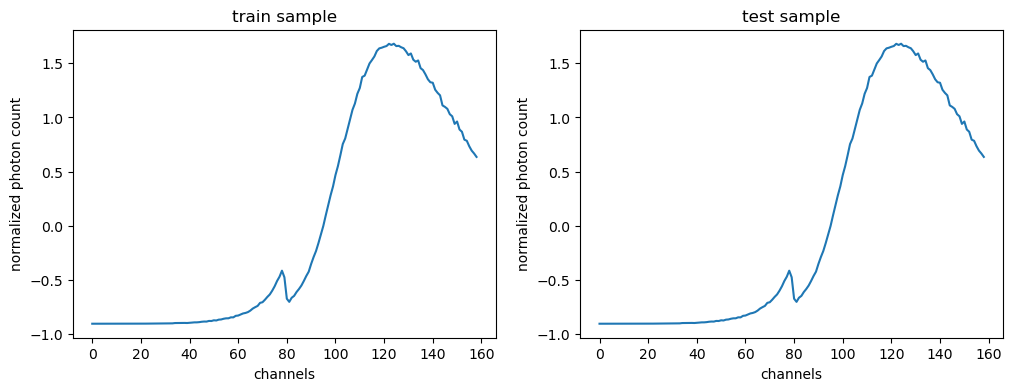

In [9]:
# Let's show a train and a test samples inside our dataloaders
# chosen randomly, from the first batch
train_features_id = torch.randint(0,len(train_features),size=[1])
test_features_id = torch.randint(0,len(test_features),size=[1])

y_train = train_features[train_features_id].squeeze().numpy()
y_test = test_features[test_features_id].squeeze().numpy()
x_channels = np.arange(0,len(y_train))

plot_pair_spectra(x_channels,y_train,x_channels,y_test,
                  title_left="train sample", title_right="test sample",
                  y_label_left="normalized photon count",
                  y_label_right="normalized photon count",
                  x_label_left="channels",
                  x_label_right="channels",
                  x_scale="linear")

# 4. Creating the PyTorch DL model

Now we create our DL model for AGN spectral analysis.

In [10]:
from torch import nn

# we want to make our code device agnostic
device = "cuda" if torch.cuda.is_available() else "cpu"

device = "cpu"# dummy code

class AGNSpectralDLModelForIronAbundance(nn.Module):
    
    def __init__(self, input_shape,hidden_units, output_shape):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(in_features=input_shape,out_features=hidden_units),
            nn.Linear(in_features=hidden_units,out_features=output_shape)
        )
    
    def forward(self, x):
        return self.layer_stack(x)


In [11]:
torch.manual_seed(42)
spectral_model = AGNSpectralDLModelForIronAbundance(input_shape=159,hidden_units=64,output_shape=1).to(device)
next(iter(spectral_model.parameters())).shape

torch.Size([64, 159])

In [12]:
# test that our model is able to return a result
dummy_x = torch.rand([159])
spectral_model(dummy_x)

tensor([-0.1394], grad_fn=<ViewBackward0>)

# 5. Creating the loss function, optimizer and timing code

We then need to create the loss function and optimizer, of course we can change these in the future.

In [17]:
# Let's now create the loss function and optimizer
loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(params=spectral_model.parameters(),lr=0.01)

In [18]:
# In addition we need to time our model, thus we need the following code for that

from timeit import default_timer as timer
from tqdm.auto import tqdm
start_time = timer()
# some code ...
end_time = timer()
print_train_time(start=start_time,end=end_time,device="cpu")


Train time on cpu: 0.000 seconds


6.951999239390716e-06